### Spontaneous otoacoustic emissions (SOAE)

SOAEs - acoustical signals generated in  the inner ear without any specific stimulation from outside. During the measurement, we place a microphone into the ear canal and record the signal in quiet.

We can found SOAEs in roughly 70% normally hearing population, which means that their lack does not indicate hearing loss and this type of OAE is not suitable for diagnosis of hearing loss. Spectrum of SOAEs is stable over time, however on average, young children have SOAEs at higher frequencies than adults.

Figures below desribe how OAEs (not only SOAEs) can be measured and show an exaple of SOAEs in three species (figures taken from Chris Bergevin, York University, Toronto, Canada)

<img src="./img/SOAEmereni.png" alt="soae" style="width: 500px;"/>

<img src="./img/SOAE.png" alt="soae" style="width: 500px;"/>


/home/vencov/miniconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


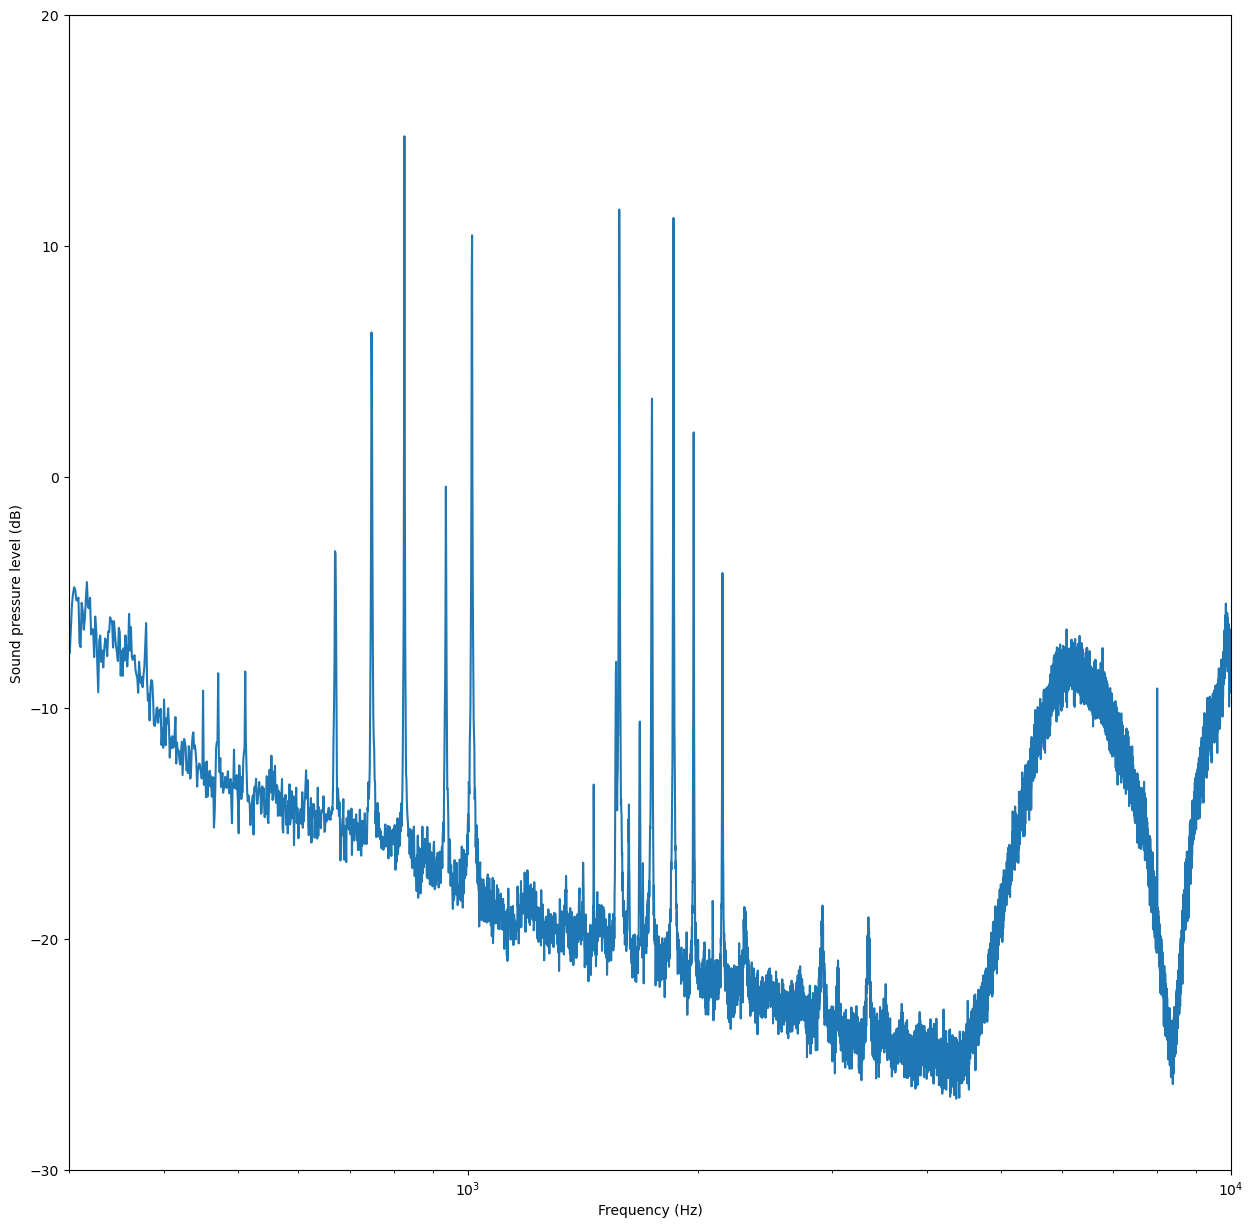

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#from scipy.io.wavfile import read
import scipy.io
from scipy import signal
from scipy.interpolate import interp1d

plt.close('all')

"""
This script loads a recorded signal from the ear canal and perform averaging in the frequency domain (1 second long windows for averaging)
The peak at 8 and 16 kHz is noise in the system (we do not know its source). The remaing peaks are SOAEs

"""




# uncomment data, which you want to lead
mat = scipy.io.loadmat('SOAE_data/soaerec_s015_Right.mat')  # measured in 2021
# data from FAV students 2022
#mat = scipy.io.loadmat('SOAE_data/soaerec_s030_220922_113928_Right.mat')
#mat = scipy.io.loadmat('SOAE_data/soaerec_s030_220922_114247_Left.mat')
#mat = scipy.io.loadmat('SOAE_data/soaerec_s034_220922_132904_Left.mat')
#mat = scipy.io.loadmat('SOAE_data/soaerec_s034_220922_133252_Right.mat')
#mat = scipy.io.loadmat('SOAE_data/soaerec_s035_220922_133904_Left.mat')
#mat = scipy.io.loadmat('SOAE_data/soaerec_s037_220922_135518_Left.mat')
#mat = scipy.io.loadmat('SOAE_data/soaerec_s037_220922_135855_Right.mat')
#mat = scipy.io.loadmat('SOAE_data/soaerec_s038_220922_140506_Left.mat')
#mat = scipy.io.loadmat('SOAE_data/soaerec_s038_220922_140801_Right.mat')


fs = int(mat['fsamp']) # sampling frequency
rec_signal = mat['RecOAE']  # recorded signal by the probe microphone (contains emission)
Hoaemicsens = mat['Hoaemicsens'] # microphone Tr. F.
GainMicA = int(mat['GainMicA'])  # microphone gain

# high-pass filter the data to romove very low frequncy fluctuations
fcutoff =100 # cutoff freq of 2order high pass butterworth filter
b, a = signal.butter(4, fcutoff/(fs/2), btype = "high", analog = False)
RSfilted = signal.filtfilt(b, a, rec_signal.flatten())

# remove the microphone freq response

Nframe = int(fs) # one second long frames
Nframes = int(np.floor(len(RSfilted)/Nframe))

Ntotal = Nframes*Nframe # total length of used samples
    
RSsel = RSfilted[:Ntotal]

#RSsel = np.reshape(RSsel,(Nframe,Nframes))

def rfft(x):
    """calculates half of signal spectrum (assumed that signal is real)"""
    if x.ndim==1:  # check whether x is 1D
        N = int(np.ceil(len(x)/2)) # half of the spectrum
        xc = np.fft.fft(x)
        X = 2*xc[0:N]/len(x)  # take first half of the spectrum and normalize
    else:
        print('Input must be a 1D array')
        X = None
    return X


#SRSsel = rfft(RSsel2)
Sp = np.zeros(int(Nframe/2))
for i in range(len(RSsel)//Nframe):
    Sp += np.abs(rfft(RSsel[i*Nframe:(i+1)*Nframe]))

Sp /= Nframes

fx = np.linspace(0,fs/2,len(Sp),endpoint=False)  # frequency axis

#fxI = np.linspace(0, 10, num=41, endpoint=True) # interpolated freq axis
fxI = np.arange(0,20e3)
SpI = interp1d(fx,Sp,kind='cubic')
SpI = SpI(fxI)

# convert to dB SPL (apply the calibration curve for the probe microphone)

Hoaemicsens = Hoaemicsens.flatten()
fxC = np.linspace(0,fs/2,len(Hoaemicsens),endpoint=False)  # frequency axis
CalCurveIR = interp1d(fxC,np.real(Hoaemicsens),kind='cubic')
CalCurveII = interp1d(fxC,np.imag(Hoaemicsens),kind='cubic')
CalCurveI = CalCurveIR(fxI) + np.emath.sqrt(-1)*CalCurveII(fxI)

CalSpect = SpI/(CalCurveI*GainMicA);

fig,ax = plt.subplots(figsize=(15,15))
ax.plot(fxI,20*np.log10(CalSpect/(np.sqrt(2)*2e-5)))
ax.set_xscale('log')
ax.set_xlim([300, 10e3])
ax.set_ylim([-30, 20])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Sound pressure level (dB)')
plt.show()
